<a href="https://colab.research.google.com/github/davidabelin/kaggle-files/blob/main/functionals_for_connectx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create ConnectX Environment

In [4]:
import random as rd
import pandas as pd
import numpy as np
import json, time, os
import zipfile as zf
import matplotlib.pyplot as plt

#### 1.15.0 for stable_baselines only #####
#!pip install 'tensorflow==1.15.0' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#@title Kaggle Only
##### FOR KAGGLE ENVS ONLY

!pip install 'kaggle-environments>=0.1.6'
from kaggle_environments import evaluate, make, utils
# Since utils.get_last_callable moved to agent.get_last_callable
# See https://github.com/Kaggle/kaggle-environments/blob/e4a5651a3a0775b823fc27fe2c24b55cbd340420/kaggle_environments/agent.py#L37
from kaggle_environments import agent as kaggle_env_agent

env = make("connectx", debug=True)

if False:
    # Check version of tensorflow
    !pip install 'tensorflow==1.15.0'
    import tensorflow as tf
    #tf.__version__

    !pip install 'kaggle-environments>=0.1.6'
    from kaggle_environments import evaluate, make, utils
    # Since utils.get_last_callable moved to agent.get_last_callable
    # See https://github.com/Kaggle/kaggle-environments/blob/e4a5651a3a0775b823fc27fe2c24b55cbd340420/kaggle_environments/agent.py#L37
    from kaggle_environments import agent as kaggle_env_agent

    env = make("connectx", debug=True)

    !apt-get update
    !apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
    !pip install "stable-baselines[mpi]==2.9.0"
    from gym import spaces
    #For Trained Agent:
    from stable_baselines import PPO1 
    from stable_baselines.common.policies import CnnPolicy

    def kaggle_agent(obs, config, model=None, debug=False):
        start = time.time()
        #Import saved model trained on Agent Heuristic
        if model is None:
            trained_model = stable_baselines.PPO1.load('/content/trained.zip', env=None, verbose=0)
        else:
            trained_model = model
        
        # Use the trained model to select a column
        col, _ = trained_model.predict(np.array(obs['board']).reshape(6,7,1))
        # Check if selected column is valid
        is_valid = (obs['board'][int(col)] == 0)
        
        if debug:
            print("\nTrained model predicted column:", col)
            print("Time taken =", time.time() - start)
        
        # If not valid, select random move. 
        if is_valid:
            return int(col)
        else:
            return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

# Collect new data

In [ ]:
from quick_pick_submit import my_agent as qps

In [ ]:
#@title stable baselines Agent
def stable_agent(obs, config, model=None, debug=False):
    start = time.time()
    #Import saved model trained on Agent Heuristic
    if model is None:
        trained_model = stable_baselines.PPO1.load('/content/trained.zip', env=None, verbose=0)
    else:
        trained_model = model
    
    # Use the trained model to select a column
    col, _ = trained_model.predict(np.array(obs['board']).reshape(6,7,1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    
    if debug:
        print("\nTrained model predicted column:", col)
        print("Time taken =", time.time() - start)
    
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [ ]:
#@title data_collector
def data_collector(obs, config, N_STEPS=2, debug=False):
    '''from Agent Quick_Pick_Submit'''
    import numpy as np
    import random
    import time

    ##############From Quick_Pick ################
    global game_df
    # constants (given by game)
    ROWS = config.rows
    COLUMNS = config.columns
    CNCTX = config.inarow
    ## coefficients
    A = 2     #my twos
    B = 20    #my threes
    C = 200   #my fours
    D = -1    #opp-twos
    E = -10    #opp-threes
    F = -100   #opp-fours
    
    # vary lookahead depth according to state of play:
    if obs.board.count(0) <= ROWS*COLUMNS//5:  # < 1/5 board empty
        N_STEPS =      rd.choice([4,5,6])
    elif obs.board.count(0) <= 3*ROWS*COLUMNS//5:  # < 3/5 board empty
        N_STEPS =      rd.choice([3,4])
    elif obs.board.count(0) <= 4*ROWS*COLUMNS//5:  # < 4/5 board empty                                          # > 3/5 board empty
        N_STEPS =      rd.choice([2,3])    
    else:                                          # > 4/5 board empty
        N_STEPS =      2  #rd.choice([1,2])

    if debug:
        print(f'\n##Data_Collector as Player {obs.mark}: Piece {1+obs.board.count(int(obs.mark))} ##') 
        print(f'Search depth: {N_STEPS} steps')
        print(f'Board:\n{np.reshape(obs.board, (6,7))}')
        
    # Gets board at next step if agent drops piece in selected column
    def drop_piece(grid, col, mark):
        next_grid = grid.copy()
        for row in range(ROWS-1, -1, -1):
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    # Helper function for get_score: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece):
        return (window.count(piece) == num_discs and window.count(0) == CNCTX-num_discs)

    # Helper function for get_score: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece):
        num_windows = 0
        # horizontal
        for row in range(ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[row, col:col+CNCTX])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # vertical
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS):
                window = list(grid[row:row+CNCTX, col])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # positive diagonal
        for row in range(ROWS-(CNCTX-1)):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row+CNCTX), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        # negative diagonal
        for row in range(CNCTX-1, ROWS):
            for col in range(COLUMNS-(CNCTX-1)):
                window = list(grid[range(row, row-CNCTX, -1), range(col, col+CNCTX)])
                if check_window(window, num_discs, piece):
                    num_windows += 1
        return num_windows

    # Helper function for alphabeta: calculates value of heuristic for grid
    def get_score(grid, mark):
        num_fours = count_windows(grid, 4, mark)   #C
        num_fours_opp = count_windows(grid, 4, mark%2+1)  #F
        is_terminal = (num_fours != 0) or (num_fours_opp != 0) or (list(grid[0, :]).count(0) == 0)
        #if debug:
        #    print (list(grid[0, :]).count(0))
        if is_terminal:
            return C*num_fours + F*num_fours_opp, is_terminal
        num_twos = count_windows(grid, 2, mark) #A
        num_threes = count_windows(grid, 3, mark)  #B
        num_twos_opp = count_windows(grid, 2, mark%2+1) #D
        num_threes_opp = count_windows(grid, 3, mark%2+1) #E
        score = A*num_twos + B*num_threes + C*num_fours + D*num_twos_opp + E*num_threes_opp + F*num_fours_opp
        return score, is_terminal

    # Minimax with alphabeta pruning implementation:
    def alphabeta(node, depth, alpha, beta, maximizingPlayer, mark):
        node_score, is_terminal = get_score(node, mark)
        if depth == 0 or is_terminal:
             return node_score

        valid_moves = [c for c in range(COLUMNS) if node[0][c] == 0]
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark)
                value = max(value, alphabeta(child, depth-1, alpha, beta, False, mark))
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
            return value

        else: #minimizing player
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark%2+1)
                value = min(value, alphabeta(child, depth-1, alpha, beta, True, mark))
                beta = min(beta, value)
                if alpha >= beta:
                    break
            return value

    def score_move(grid, col, mark, depth):
        go = time.time()
        next_grid = drop_piece(grid, col, mark)
        score = alphabeta(next_grid, depth-1, -np.Inf, np.Inf, False, mark)
        if debug:
            summary_stats = {
                'column': col,
                'score': score,
                'column time': round(time.time() - go, 5),
                'time_left': round(2.0 - (time.time() - choice_time), 5)           
            }
            print(f'"summary_stats":{summary_stats}')
        return score
     
    def first_pass(grid, col, mark):
        score, self_is_terminal = get_score(drop_piece(grid, col, mark), mark)
        score, opp_is_terminal = get_score(drop_piece(grid, col, mark%2+1), mark%2+1)
        return self_is_terminal or opp_is_terminal

    #########################
    # Agent makes selection #
    #########################

    # Get list of valid moves
    valid_moves = [c for c in range(COLUMNS) if obs.board[c] == 0]

    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(ROWS, COLUMNS)

    # Do a quick pass to see if there is a terminal node on the surface 
    choice_time = time.time()
    scores = {}   
    quick_pick = False
    for col in valid_moves:
        quick_pick = first_pass(grid, col, obs.mark)
        if quick_pick:
            choice = col   
            for c in range(COLUMNS):
                if c == choice:
                    scores[c] = C # my_fours, starting 200
                else:
                    if c in valid_moves:
                        scores[c] = F # opp_fours, starting -100
                    else:
                        scores[c] = -np.inf       
            if debug:
                print("Column {} is terminal.".format(choice))
            break
    
    if not quick_pick:   
        # Use the heuristic to assign a score to each possible board in the next step
        for col in range(COLUMNS):
            if col in valid_moves:
                scores[col] = score_move(grid, col, obs.mark, N_STEPS) 
            else:
                scores[col] = -np.inf

        # Get a list of columns (moves) that maximize the heuristic
        if max(scores.values()) > 0:
            max_cols = [key for key in scores.keys() if scores[key] >= 0.667*max(scores.values())]
        else:
            max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
        if debug and len(max_cols) > 1:
            print("Max columns:", max_cols)
        #select column in order of preference
        for pref in [3,4,2,5,1,6,0]: 
            if pref in max_cols:
                choice = pref
                break
            else:
                choice = 3 #random.choice(max_cols)
    if debug:
        print("Chosen column:", choice)
        print("Choice took:", round(time.time()-choice_time,5))

    new_row = pd.Series([choice]+[obs.mark]+[0]+[float(s) for s in scores.values()]+[x for x in obs.board],
                        index=game_df.columns)
    
    game_df = game_df.append(new_row.T, ignore_index=True)

    return choice


#Load data

In [6]:
board_cols = ['b' + str(x) for x in range(42)]

def shuffle_index(df):
    new_index = []
    idx = pd.Series(df.index)
    while not idx.empty:
        new_index.append(idx.pop(rd.choice(idx.index)))
    return new_index

In [25]:
#### Load Player 1 data

p1_winsA = pd.read_csv("p1wins_A", index_col=0)
p1_winsB = pd.read_csv("p1wins_B", index_col=0)
p1_winsC = pd.read_csv("p1wins_C", index_col=0)
p1_winsD = pd.read_csv("p1wins_D", index_col=0)
p1_winsE = pd.read_csv("p1wins_E", index_col=0)
p1_winsF = pd.read_csv("p1wins_F", index_col=0)
p1_winsG = pd.read_csv("p1wins_G", index_col=0)
p1_winsH = pd.read_csv("p1wins_H", index_col=0)
p1_winsI = pd.read_csv("p1wins_I", index_col=0)

p1_wins = p1_winsA.append(p1_winsB, ignore_index=True) \
                .append(p1_winsC, ignore_index=True) \
                .append(p1_winsD, ignore_index=True) \
                .append(p1_winsE, ignore_index=True) \
                .append(p1_winsF, ignore_index=True) \
                .append(p1_winsG, ignore_index=True) \
                .append(p1_winsH, ignore_index=True) \
                .append(p1_winsI, ignore_index=True) \

p1_wins = p1_wins.reindex(shuffle_index(p1_wins))

train_boards_p1_df = p1_wins[:int(p1_wins.shape[0]*0.9)][board_cols]
train_labels_p1_df = p1_wins[:int(p1_wins.shape[0]*0.9)]["choice"]
train_boards_p1 = np.array(train_boards_p1_df)
train_labels_p1 = np.array(train_labels_p1_df)

test_boards_p1_df = p1_wins[int(p1_wins.shape[0]*0.9):][board_cols]
test_labels_p1_df = p1_wins[int(p1_wins.shape[0]*0.9):]["choice"]
test_boards_p1 = np.array(test_boards_p1_df)
test_labels_p1 = np.array(test_labels_p1_df)


In [ ]:
select = [name for name in p1_wins.columns[:4]]
p1_wins.loc[lambda df: df["piece"]==1][select].describe()

In [ ]:

#heatmap = sbs.heatmap(p1_winsA[cols+["choice"]].corr())
#sbs.heatmap(p1_winsA[cols+["choice"]].corr())
#fig.add_subplot(111,)
#sbs.heatmap(p1_winsB[cols+["choice"]].corr())
#fig.add_subplot(122)
sbs.heatmap(p1_winsF[cols+["choice"]].corr())
#fig.add_subplot(1,2,1)
#plt.subplot()
plt.show()

In [ ]:
#heatmap = sbs.heatmap(p1_wins[["choice"]+board_cols[-7:]].loc[lambda df:df["choice"]==5])#.corr())
#plt.bar(p1_winsG, height=3) #,p1_winsG[cols])
#heatmap2 = sbs.heatmap(p1_winsG[cols+["choice"]].corr())
p1_winsG.hist()
fig.show()

In [377]:
#@title Load Player 2 data

board_cols = ['b' + str(x) for x in range(42)]

p2_winsA = pd.read_csv("p2wins/p2wins_A", index_col=0)
p2_winsB = pd.read_csv("p2wins/p2wins_B", index_col=0)
p2_winsC = pd.read_csv("p2wins/p2wins_C", index_col=0)
p2_winsD = pd.read_csv("p2wins/p2wins_D", index_col=0)
p2_winsE = pd.read_csv("p2wins/p2wins_E", index_col=0)
p2_winsF = pd.read_csv("p2wins/p2wins_F", index_col=0)
p2_winsG = pd.read_csv("p2wins/p2wins_G", index_col=0)
p2_winsH = pd.read_csv("p2wins/p2wins_H", index_col=0)
p2_winsI = pd.read_csv("p2wins/p2wins_I", index_col=0)

p2_wins_AI = p2_winsA.append(p2_winsB, ignore_index=True) \
                  .append(p2_winsC, ignore_index=True) \
                  .append(p2_winsD, ignore_index=True) \
                  .append(p2_winsE, ignore_index=True) \
                  .append(p2_winsF, ignore_index=True) \
                  .append(p2_winsG, ignore_index=True) \
                  .append(p2_winsH, ignore_index=True) \
                  .append(p2_winsI, ignore_index=True) \

p2_wins_AI = p2_wins_AI.reindex(shuffle_index(p2_wins))

#board_cols = ['b' + str(x) for x in range(42)]
train_boards_p2_df = p2_wins[:int(p2_wins.shape[0]*0.9)][board_cols]
train_labels_p2_df = p2_wins[:int(p2_wins.shape[0]*0.9)]["choice"]
train_boards_AI = np.array(train_boards_p2_df)
train_labels_AI = np.array(train_labels_p2_df)

test_boards_p2_df = p2_wins[int(p2_wins.shape[0]*0.9):][board_cols]
test_labels_p2_df = p2_wins[int(p2_wins.shape[0]*0.9):]["choice"]
test_boards_AI = np.array(test_boards_p2_df)
test_labels_AI = np.array(test_labels_p2_df)


In [ ]:
#@title def znorm()

def znorm(data):
    ''' Returns a normalized set of data
        data: list-like
    '''

    min = np.min([d for d in data if d > -np.inf])
    max = np.max(data)
    if max == min:
        norm = [0 for _ in data]
    else:    
        norm = [(z - min)/(max-min) if z > -np.inf else float(-1) for z in data]
    return norm

znorm([23,23,-np.inf,23,23,23,0])

# Evaluation

In [ ]:
#Replay
#env.render(mode="ipython", width=488, height=500)

In [9]:
#@ title Trained Agent
def model_agent(obs, config, model_p1=None, model_p2=None, player="", debug=False):
    global game_df
    valid_moves = [c for c in range(7) if obs.board[c] == 0]
    board = np.array(obs.board).reshape(1,6,7,1)
        
    if obs.mark == 1:
        scores = model_p1(board).numpy()
    else:
        scores = model_p2(board).numpy()
    
    scores = [int(s*100) if s > 0.001 else -1*int(s*100000) for s in scores[0]]
    choice = int(np.argmax(scores))
    if not choice in valid_moves:
        return rd.choice(valid_moves)

    new_row = pd.Series([choice]+[obs.mark]+[1+obs.board.count(int(obs.mark))]+ \
                        [0]+[s for s in scores]+ \
                        [x for x in obs.board],
                        index=game_df.columns)      
    game_df = game_df.append(new_row.T, ignore_index=True)  
    if debug:
            print (f"\nModel {player} as player {obs.mark} predicts: {choice}")
    return choice 

twoD_p1_agent = lambda x,y: trained_agent(x,y,model=twoD_p1_AG, 
                                        player = "twoD_p1",
                                        debug=False)
twoD_p2_agent = lambda x,y: trained_agent(x,y,model=twoD_p2_AG,  
                                        player = "twoD_p2",
                                        debug=False)

In [ ]:
agent3 = lambda x,y: model_agent(x,y, modela= twoD_p1_AG, modelb = twoD_p2_AG, debug=True)

In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=10):
    # Use default Connect Four setup
    #import numpy as np
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time  

    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 3))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 3))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    return outcomes

In [ ]:
evaluate("connectx", [agent1, agent3], config, [], n_rounds)

In [ ]:
env.run([agent1, agent3])

In [ ]:
plt.imshow(train_boards_p1[idx].reshape(6,7))
#twoD_p1_AG(train_boards_p1[1].reshape(1,6,7,1))

In [ ]:
idx = rd.randint(0,train_boards_p1.shape[0]-1)
print("Answer:",train_labels_p1[idx])
guesses = twoD_p1_AG(train_boards_p1[idx].reshape(1,6,7,1)).numpy()
print("Guesses:", [round(g*100,4) for g in guesses[0]])
print("Prediction:", np.argmax(guesses),"\nFor board:")

plt.imshow(train_boards_p1[idx].reshape(6,7))


In [ ]:
agent1 = "negamax"
agent2a = twoD_p1_agent
agent2b = twoD_p2_agent
#agent3
num_episodes = 2
start = time.time()
outcomes = get_win_percentages(agent1, agent3, num_episodes)
end = time.time()
print ("Total time:",round(end-start,3),"\tAvg game time:",round((end-start)/num_episodes,3))

In [ ]:
num_episodes = 111
start = time.time()
outcomes = get_win_percentages(test_agent, test_agent_v4, num_episodes)
end = time.time()
print ("Total time:",round(end-start,3),"\tAvg game time:",round((end-start)/num_episodes,3))



*   Agent 1 Win Percentage: 0.48
*   Agent 2 Win Percentage: 0.52
*   Number of Invalid Plays by Agent 1: 0
*   Number of Invalid Plays by Agent 2: 0
*   Total time: 224.808 	Avg game time: 6.812



In [ ]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
num_episodes = 33
agent1 = test_agent
agent2 = test_agent_v4   #  "negamax"
if debug:
    print("Debug Agent goes first:", mean_reward(evaluate("connectx", [agent1, agent2], num_episodes)))
    print("Opp Agent goes first:", mean_reward(evaluate("connectx", [agent2, agent1], num_episodes)))

In [ ]:
# Play as first position against random agent.
trainer = env.train([None, "negamax"])

observation = trainer.reset()

while not env.done:
    my_action = agent1(observation, env.configuration)
    print("My Action", my_action)
    observation, reward, done, info = trainer.step(my_action)
    env.render(mode="ipython", width=100, height=90, header=False, controls=False)
#env.render()

#Functional Models

##Build Player1

In [ ]:
# convolution model 
input = keras.Input(shape=(6,7,1), name="input")
x = layers.Conv2D(77,2,padding='same', activation='relu', input_shape=(6,7,1))(input)
x = layers.AveragePooling2D(2)(x)
x = layers.Flatten()(x)

y = layers.Conv2D(77,2,padding='same', activation='relu', input_shape=(6,7,1))(input)
y = layers.MaxPooling2D(2)(y)
y = layers.Flatten()(y)

xx = layers.Conv2D(111,2,padding='same', activation='relu', input_shape=(6,7,1))(input)
xx = layers.Conv2D(77,3,activation='relu')(xx)
xx = layers.Flatten()(xx)

z = layers.Concatenate()([x, y, xx])
z = layers.Dropout(0.3)(z)
z = layers.Dense(777,activation='relu')(z)
z = layers.Dropout(0.2)(z)

output = layers.Dense(7,activation="softmax")(z)

twoD = keras.Model(input,output,name="twoD")

twoD.summary()

In [448]:
#@ title flat model 
input = keras.Input(shape=(42))
x = layers.Dense(840,activation='relu')(input)
x = layers.Dropout(0.2)(x)
#x = layers.Dense(42,activation='relu')(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(210,activation='relu')(x)
x = layers.Dropout(0.1)(x)

y = layers.Dense(168,activation='relu')(input)
y = layers.Dropout(0.333)(y)
#y = layers.Dense(63,activation='relu')(y)
#y = layers.Dropout(0.1)(y)
y = layers.Dense(210,activation='relu')(y)
y = layers.Dropout(0.1)(y)

o = layers.Concatenate()([x,y])
#o = layers.Dense(84,activation='relu')(o)
#o = layers.Dropout(0.2)(o)
o = layers.Dense(210,activation='relu')(o)
o = layers.Dropout(0.1)(o)

output = layers.Dense(7,activation="softmax")(o)
#output = layers.Dense(1,activation="sigmoid")(x)  #<< for each column?

flat = keras.Model(input,output,name="flat")
flat.summary()

Model: "flat"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 840)          36120       input_4[0][0]                    
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 168)          7224        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 840)          0           dense_43[0][0]                   
_______________________________________________________________________________________________

###Train Player1

In [449]:
learning_rate = 0.005
batch_size = 82
validation_split = 0.075
training_epochs = 25

In [450]:
epoch_count = pd.DataFrame()
train_hist = pd.DataFrame(columns=["loss","accuracy","val_loss","val_accuracy"])

#checkpoint_path = "twoD/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

In [405]:
def train_model(model, train_features, train_labels, epochs=training_epochs,
                batch_size=None, validation_split=validation_split,
                callbacks=None):

    history = model.fit(x=train_features, y=train_labels, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split,
                        verbose = 1,
                        callbacks=callbacks)

    epoch_count = history.epoch
    hist = pd.DataFrame(history.history)
    return epoch_count, hist

In [451]:
twoD.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']) 

flat.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']) 

In [428]:
train_boards_AG = train_boards_AG.reshape(13290,42)
train_boards_p1 = train_boards_p1.reshape(18873,42)
train_boards_AD = train_boards_AD.reshape(9540,42)
train_boards_EI = train_boards_EI.reshape(9332,42)

In [436]:
hi_boards = [np.sum(board) for board in train_boards_HI]
ad_boards = [np.sum(board) for board in train_boards_AD]
#np.mean(hi_boards)
plt.scatter(range(len(ad_boards)),ad_boards)

21.076415094339623

In [ ]:
ec, th = train_model(flat, 
                    train_boards_p1, 
                    train_labels_p1,
                    epochs=training_epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    callbacks=None)#[cp_callback])

epoch_count = epoch_count.append([val + len(epoch_count) + 1 for val in ec], ignore_index=True)
train_hist = train_hist.append(th, ignore_index=True)

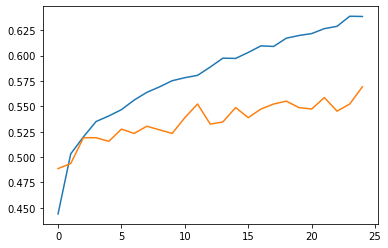

In [453]:
plt.plot(list(train_hist.index), train_hist["accuracy"] )
plt.plot(list(train_hist.index), train_hist["val_accuracy"])

In [ ]:
plt.plot(list(train_hist.index), train_hist["loss"] )
plt.plot(list(train_hist.index), train_hist["val_loss"])

In [433]:
test_boards_AG = test_boards_AG.reshape(1477,42)
test_boards_p1 = test_boards_p1.reshape(2097,42)
test_boards_AD = test_boards_AD.reshape(1061,42)

flat.evaluate(x=test_boards_AD, y=test_labels_AD, batch_size=batch_size)

# model twoD reults:
#test_boards_AI accuracy: 0.6285 AI \\ 0.6385 AG
#test_boards_AD accuracy: 0.7154 AD \\ 0.7700 AG \\ 0.8341 AI \\ 0.6268 HI
#test_boards_EG accuracy: 0.5372 EG \\ 0.6787 AG \\ 0.8058 AI 
#test_boards_HI accuracy: 0.3478 HI \\ 0.3366 AG \\ 0.7230 AI 
#test_boards_EI accuracy: 0.4716 EI \\ 0.4744 AG \\ 0.7599 AI 
#test_boards_AG accuracy: 0.6412 AG              \\ 0.8267 AI

13/13 [==============================] - 0s 2ms/step - loss: 0.8285 - accuracy: 0.7088


[0.8284518718719482, 0.7087653279304504]

In [342]:
test_boards_EI = test_boards_EI.reshape(1037,6,7,1)
twoD_p1_og.evaluate(x=test_boards_EI, y=test_labels_EI, batch_size=batch_size)
#test_boards_AI accuracy: 0.6061
#test_boards_AD accuracy: 0.8238
#test_boards_EG accuracy: 0.4748
#test_boards_HI accuracy: 0.2721
#test_boards_EI accuracy: 0.3510
#test_boards_AG accuracy: 0.7285

26/26 [==============================] - 0s 7ms/step - loss: 4.6547 - accuracy: 0.3510


[4.654711723327637, 0.35101252794265747]

In [343]:
idx = rd.randint(0,test_boards_p1.shape[0]-1)
print ("Choice =", test_labels_p1[idx])
preds = twoD(test_boards_p1[idx].reshape(1,6,7,1)).numpy()[0]
print ("Preds =\n", preds)
print ("Prediction =", np.argmax(preds))

Choice = 5.0
Preds =
 [6.4512377e-04 1.9996172e-02 1.2678219e-02 2.6383135e-03 8.3109009e-01
 1.2987614e-01 3.0759603e-03]
Prediction = 4


In [360]:
guesses_p1 = [np.argmax(p) for p in twoD.predict(test_boards_p1)]
guesses_p1_og = [np.argmax(p) for p in twoD_p1_og.predict(test_boards_p1)]
comparison_p1 = pd.DataFrame(columns=["Choice","Guess","OG"])
comparison_p1["Choice"] = test_labels_p1
comparison_p1["Guess"] = guesses_p1
comparison_p1["OG"] = guesses_p1_og

In [362]:
comparison_p1.loc[lambda df: df["Guess"] != df["OG"]]

,Choice,Guess,OG
9,3.0,5,3
12,2.0,5,2
13,5.0,5,3
15,5.0,5,1
21,0.0,1,4
...,...,...,...
2087,1.0,3,1
2089,2.0,6,2
2091,1.0,5,1
2095,3.0,0,3


In [ ]:
for idx in range(test_boards_p1.shape[0]):
    choice = test_labels_p1[idx]
    preds = twoD_p1_og(test_boards_p1[idx].reshape(1,6,7,1)).numpy()[0]
    prediction = np.argmax(preds)
    if choice == prediction:
        print("Index:",idx,"Choice =",choice,"Prediction =",prediction)

In [ ]:
#twoD_origdata accuracy: 0.7856
#twoD_trained_on_data_df accuracy: 0.9553
#twoD_og_untrained  #accuracy: 0.8061
#twoD trained on orig data accuracy: 0.7947
#twoD_og_trained accuracy: 0.9560
#twoD_og_partly_trained_on_data_df accuracy: 0.9553
#twoD_trained_on_data_df = twoD  accuracy: 0.5281
#twoD_og_trained_on_data_df  accuracy: 0.6330
#twoD_og  accuracy: 0.7271

In [67]:
zf.shutil.unpack_archive("twoD_p1_og.zip", "restored/twoD_p1_og")
twoD_p1_og = tf.keras.models.load_model('./restored/twoD_p1_og')
#for layer in twoD_og.layers:#[:-3]:
    #layer.trainable = False
#    print(layer.trainable)

In [ ]:
#### Save whole model
twoD.save('saved_models/twoD_p1_AG')
#new_twoD = tf.keras.models.load_model('./saved_models/twoD_p1')

#### Zip whole model
zf.shutil.make_archive("twoD_p1_AG", 'zip', 'saved_models/twoD_p1_AG')
#zf.shutil.unpack_archive("twoD_p1.zip", "restored/twoD_p1")

'/content/twoD_p1.zip'

##Build Player2

In [378]:
# convolution model 
input = keras.Input(shape=(6,7,1), name="input")
x = layers.Conv2D(77,2,padding='same', activation='relu', input_shape=(6,7,1))(input)
x = layers.AveragePooling2D(2)(x)
x = layers.Flatten()(x)

y = layers.Conv2D(77,2,padding='same', activation='relu', input_shape=(6,7,1))(input)
y = layers.MaxPooling2D(2)(y)
y = layers.Flatten()(y)

xx = layers.Conv2D(111,2,padding='same', activation='relu', input_shape=(6,7,1))(input)
xx = layers.Conv2D(77,3,activation='relu')(xx)
xx = layers.Flatten()(xx)

z = layers.Concatenate()([x, y, xx])
z = layers.Dropout(0.4)(z)
z = layers.Dense(777,activation='relu')(z)
z = layers.Dropout(0.3)(z)

output = layers.Dense(7,activation="softmax")(z)

twoD_p2 = keras.Model(input,output,name="twoD_p2")

twoD_p2.summary()

Model: "twoD_p2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 6, 7, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 6, 7, 77)     385         input[0][0]                      
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 6, 7, 77)     385         input[0][0]                      
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 6, 7, 111)    555         input[0][0]                      
____________________________________________________________________________________________

In [ ]:
#@title flat model 
input = keras.Input(shape=(42))
x = layers.Dense(512,activation='relu')(input)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)

y = layers.Dense(512,activation='relu')(input)
y = layers.Dropout(0.4)(y)
y = layers.Dense(256,activation='relu')(y)
y = layers.Dropout(0.2)(y)

o = layers.Concatenate()([x,y])
o = layers.Dropout(0.4)(o)
o = layers.Dense(256,activation='relu')(o)
o = layers.Dropout(0.2)(o)

output = layers.Dense(7,activation="softmax")(o)
#output = layers.Dense(1,activation="sigmoid")(x)  #<< for each column?

flat_p2 = keras.Model(input,output,name="flat")
flat_p2.summary()

###Train Player2

In [ ]:
#@title define train_model
def train_model(model, train_features, train_labels, epochs=training_epochs,
                batch_size=None, validation_split=validation_split,
                callbacks=None):

    history = model.fit(x=train_features, y=train_labels, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split,
                        verbose = 1,
                        callbacks=callbacks)

    epoch_count = history.epoch
    hist = pd.DataFrame(history.history)
    return epoch_count, hist

In [379]:
learning_rate = 0.0075
batch_size = 55
validation_split = 0.05
training_epochs = 30

In [380]:
epoch_count = pd.DataFrame()
train_hist = pd.DataFrame(columns=["loss","accuracy","val_loss","val_accuracy"])

#checkpoint_path = "twoD_p2/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

In [381]:
twoD_p2.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']) 

#flat_p2.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
#                loss="sparse_categorical_crossentropy",
#                metrics=['accuracy']) 

In [382]:
train_boards_AI = train_boards_AI.reshape(6289,6,7,1)
#train_boards_p2 = train_boards_p2.reshape(3828,42)

In [383]:
# Train and plot
ec, th = train_model(twoD_p2, 
                    train_boards_AI, 
                    train_labels_AI,
                    epochs=training_epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    callbacks=None)#[cp_callback])

epoch_count = epoch_count.append([val + len(epoch_count) + 1 for val in ec], ignore_index=True)
train_hist = train_hist.append(th, ignore_index=True)

Epoch 1/30
109/109 [==============================] - 4s 35ms/step - loss: 2.2150 - accuracy: 0.1929 - val_loss: 1.7448 - val_accuracy: 0.2762
Epoch 2/30
109/109 [==============================] - 4s 35ms/step - loss: 1.7132 - accuracy: 0.2999 - val_loss: 1.6211 - val_accuracy: 0.3556
Epoch 3/30
109/109 [==============================] - 4s 34ms/step - loss: 1.6310 - accuracy: 0.3376 - val_loss: 1.5747 - val_accuracy: 0.3492
Epoch 4/30
109/109 [==============================] - 4s 33ms/step - loss: 1.5734 - accuracy: 0.3696 - val_loss: 1.5148 - val_accuracy: 0.3587
Epoch 5/30
109/109 [==============================] - 4s 33ms/step - loss: 1.5455 - accuracy: 0.3814 - val_loss: 1.4842 - val_accuracy: 0.3937
Epoch 6/30
109/109 [==============================] - 4s 32ms/step - loss: 1.4906 - accuracy: 0.4117 - val_loss: 1.5050 - val_accuracy: 0.3905
Epoch 7/30
109/109 [==============================] - 4s 33ms/step - loss: 1.4725 - accuracy: 0.4104 - val_loss: 1.4291 - val_accuracy: 0.4286

In [ ]:
epoch_count

In [ ]:
#ec = ec.append([val + len(epoch_count) for val in ec])
#th = train_hist.append(th, ignore_index=True)

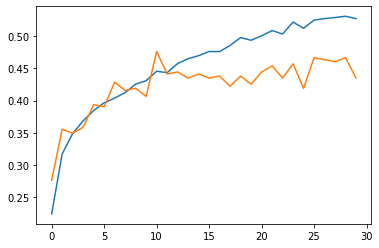

In [387]:
plt.plot(list(train_hist.index), train_hist["accuracy"] )
plt.plot(list(train_hist.index), train_hist["val_accuracy"])

In [388]:
test_boards_AI = test_boards_AI.reshape(699,6,7,1)
#test_boards_p2 = test_boards_p2.reshape(426,42)

twoD_p2.evaluate(x=test_boards_AI, y=test_labels_AI)

22/22 [==============================] - 0s 8ms/step - loss: 1.3354 - accuracy: 0.4449


[1.335378885269165, 0.4449213147163391]

In [ ]:
twoD_p2_og.evaluate(x=test_boards_p2, y=test_labels_p2)

24/24 [==============================] - 0s 6ms/step - loss: 2.9583 - accuracy: 0.2777


[2.9582860469818115, 0.2777053415775299]

In [ ]:
#### Save whole model
twoD_p2.save('saved_models/twoD_p2')
#restore_twoD = tf.keras.models.load_model('./restored/twoD_p2')

#### Zip whole model
zf.shutil.make_archive("twoD_p2", 'zip', 'saved_models/twoD_p2')
#zf.shutil.unpack_archive("twoD_p2.zip", "restored/twoD_p2")

INFO:tensorflow:Assets written to: saved_models/twoD_p2/assets


'/content/twoD_p2.zip'

In [ ]:
zf.shutil.unpack_archive("twoD_p2_AD.zip", "restored/twoD_p2_AD")
twoD_p2_og = tf.keras.models.load_model('restored/twoD_p2_AD')